<div style="text-align: center; color: red; font-size: 40px">DEEP LEARNING MODELS</div>

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tqdm as tqdm

import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from collections import defaultdict

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.utils import to_categorical

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2025-05-19 17:00:29.374271: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 17:00:29.380990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 17:00:29.401063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747663229.436221   11196 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747663229.447103   11196 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747663229.471599   11196 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<div style="color: blue; font-size: 30px">1. CONVOLUTIONAL NEURAL NETWORKS</div>

<div style="color: green; font-size: 25px">Visualizations</div>

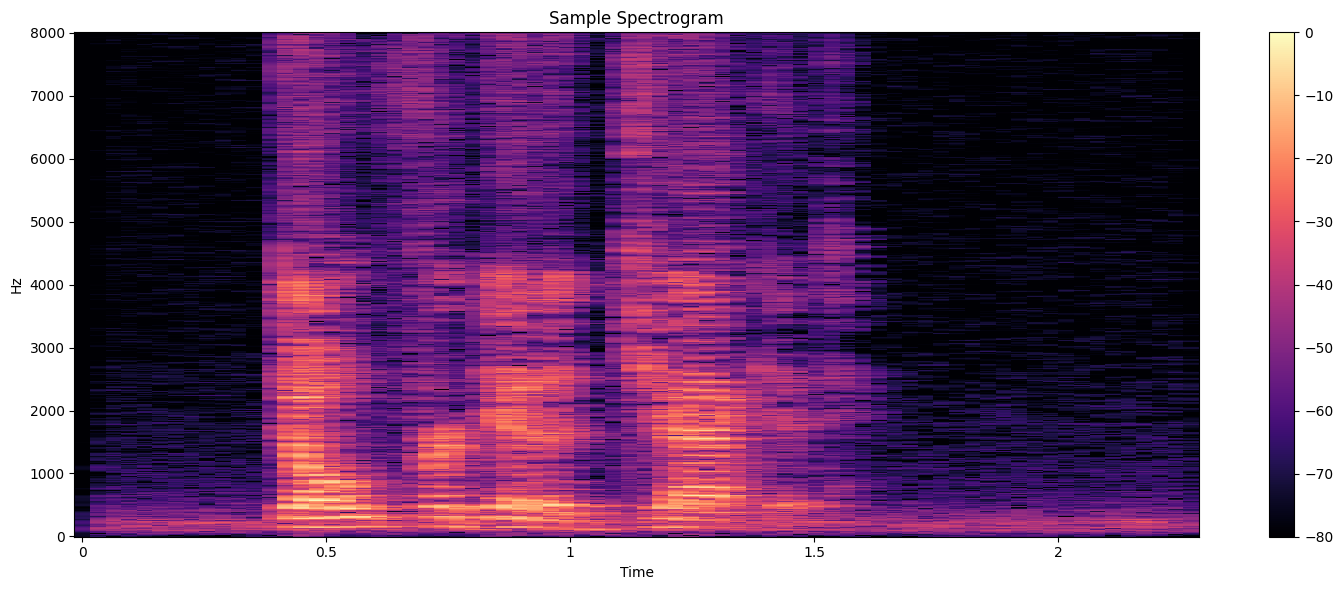

In [2]:
# Visualize sample spectrogram
y, sr = librosa.load("../data/1001_DFA_ANG_XX.wav", sr=None)
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
# Plot
plt.figure(figsize=(15, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.title('Sample Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

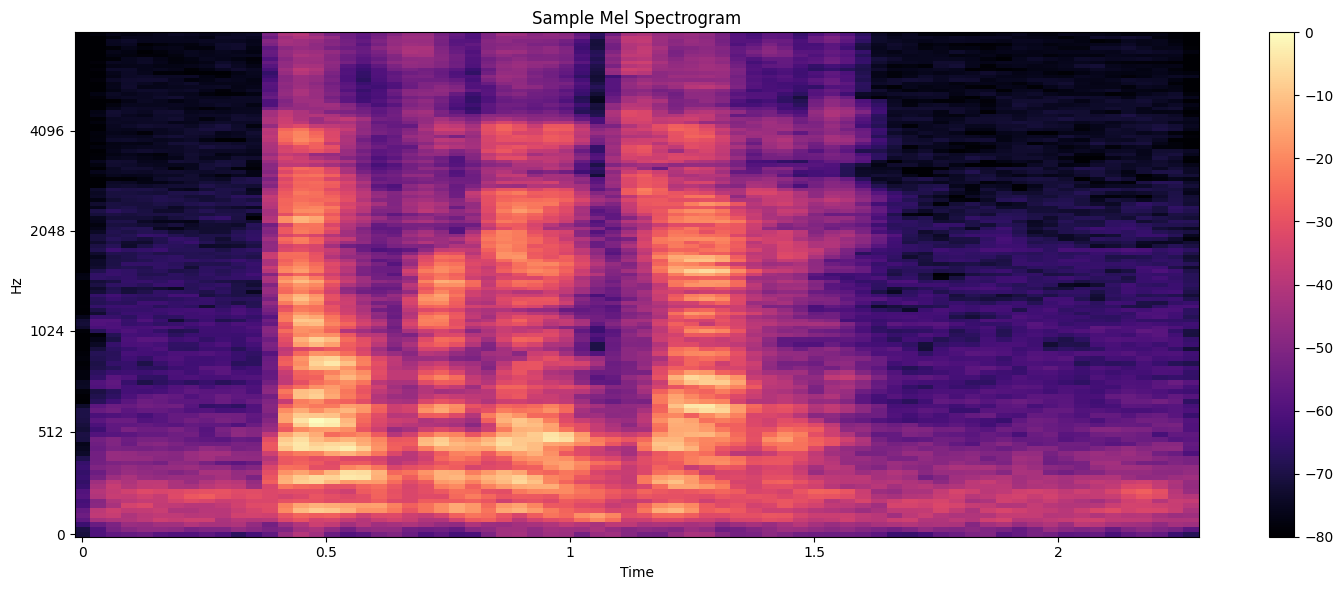

In [3]:
# Visualize Mel Spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)
# Plot
plt.figure(figsize=(15, 6))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('Sample Mel Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

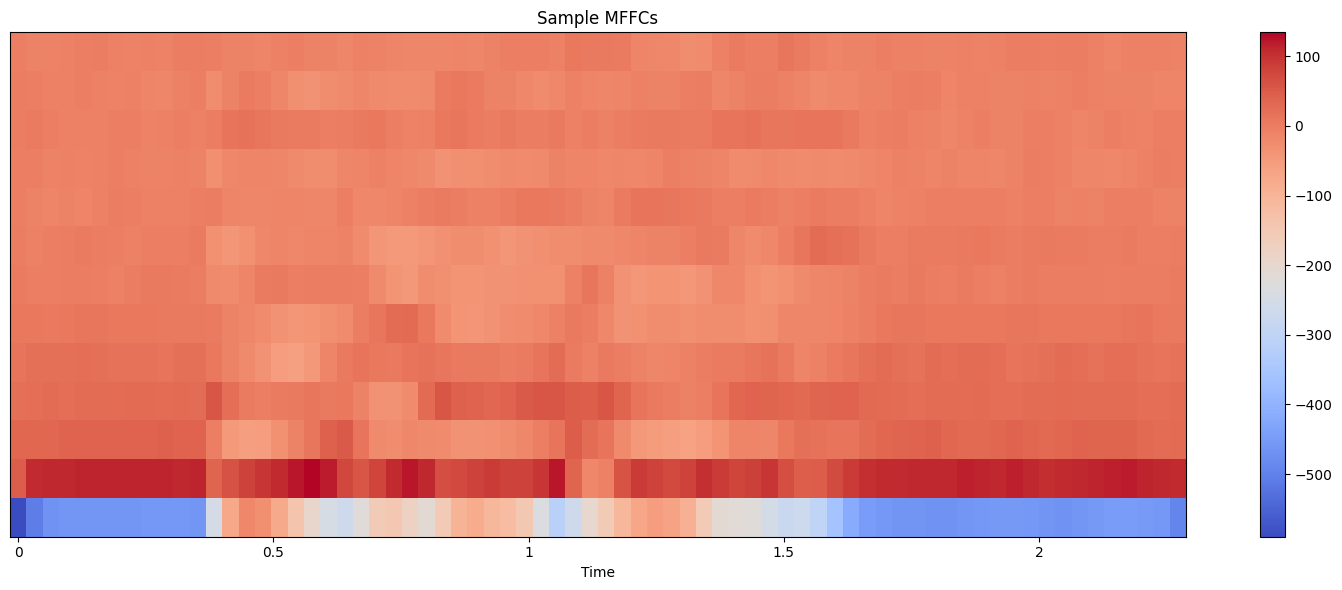

In [4]:
# Visualize MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
# Plot
plt.figure(figsize=(15, 6))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.title('Sample MFFCs')
plt.colorbar()
plt.tight_layout()
plt.show()

In [5]:
mfcc.shape

(13, 72)

<div style="color: green; font-size: 25px">Preprocessing</div>

In [6]:
# Data Augmentation
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)
])

In [7]:
# Fix length and normalize audio function
def fix_length(y, target_len = sr*3):
    # Target is 3 seconds
    if len(y) > target_len:
        y_trunc = y[:target_len]
        return y_trunc
    else:
        y_pad = np.pad(y, (0, target_len - len(y)))
        return y_pad

def preprocess(file):
    try:
        # Load audio
        y, sr = librosa.load(file, sr=16000)
        # Fix length
        fixed_len = fix_length(y)
        # Peak normalization
        peak = np.max(np.abs(fixed_len))
        target_peak = 0.99
        normalized_audio = fixed_len/peak * target_peak * 0.95
    except Exception as e:
        print(f'Error processing {path}: {e}')
    return normalized_audio

In [8]:
# Extract mffcs
def extract_mfccs(y, sr=16000):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc

<div style="color: green; font-size: 25px">Splitting</div>

In [9]:
emotion_map = {
        'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful',
        'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}

In [10]:
# Define folds
folds = {
    1: list(range(1037, 1055)),
    2: list(range(1001, 1019)),
    3: list(range(1073, 1092)),
    4: list(range(1055, 1073)),
    5: list(range(1019, 1037))
}

# Define path to files
path = "../data/"

# Fold files variable
fold_files = defaultdict(list)

# The iteration
for filename in os.listdir(path):
    # Get speaker id
    speaker_id = int(filename.split('_')[0])
    # Match id to its fold and append filename
    for fold_num, speakers in folds.items():
        if speaker_id in speakers:
            fold_files[fold_num].append(filename)
            break

In [11]:
# Assign files to sets
train_files = []
val_files = []
test_files = []
# Iterate and add files to respective list
for fold_num, paths in fold_files.items():
    if fold_num == 1 or fold_num == 2 or fold_num == 3:
        for path in paths:
            train_files.append(f"../data/{path}")
    elif fold_num == 4:
        for path in paths:
            val_files.append(f"../data/{path}")
    else:
        for path in paths:
            test_files.append(f"../data/{path}")

In [12]:
print(f"Number of training files: {len(train_files)}")
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

Number of training files: 4496
Number of validation files: 1476
Number of test files: 1470


In [13]:
# Split files
X_train = []
y_train = []
for file in tqdm.tqdm(train_files):
    # Preprocess audio
    try:
        # Step 1: Preprocess audio
        y_processed = preprocess(file)
        
        # Step 2: Extract features
        try:
            mfccs = extract_mfccs(y_processed)
            X_train.append(mfccs)
            
            # Step 3: Extract label
            label = file.split('_')[-2]
            y_train.append(emotion_map[f"{label}"])
        except Exception as e:
            print(f"Error extracting features from {file}: {e}")
            continue

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

 93%|████████████████████████████████████▎  | 4184/4496 [01:05<00:09, 33.93it/s]

Error extracting features from ../data/1076_MTI_SAD_XX.wav: Audio buffer is not finite everywhere


100%|███████████████████████████████████████| 4496/4496 [01:12<00:00, 61.82it/s]


In [14]:
# Split files
X_val = []
y_val = []
for file in tqdm.tqdm(val_files):
    # Preprocess audio
    try:
        # Step 1: Preprocess audio
        y_processed = preprocess(file)
        
        # Step 2: Extract features
        try:
            mfccs = extract_mfccs(y_processed)
            X_val.append(mfccs)
            
            # Step 3: Extract label
            label = file.split('_')[-2]
            y_val.append(emotion_map[f"{label}"])
        except Exception as e:
            print(f"Error extracting features from {file}: {e}")
            continue

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

100%|███████████████████████████████████████| 1476/1476 [00:27<00:00, 54.42it/s]


In [15]:
# Split files
X_test = []
y_test = []
for file in tqdm.tqdm(test_files):
    # Preprocess audio
    try:
        # Step 1: Preprocess audio
        y_processed = preprocess(file)
        
        # Step 2: Extract features
        try:
            mfccs = extract_mfccs(y_processed)
            X_test.append(mfccs)
            
            # Step 3: Extract label
            label = file.split('_')[-2]
            y_test.append(emotion_map[f"{label}"])
        except Exception as e:
            print(f"Error extracting features from {file}: {e}")
            continue

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

100%|███████████████████████████████████████| 1470/1470 [00:25<00:00, 57.69it/s]


<div style="color: green; font-size: 25px">The Model</div>

In [16]:
# Convert list to numpy array
X_train = np.stack(X_train)
X_train.shape

(4495, 40, 94)

In [17]:
# Flatten for scaler
X_train_flat = X_train.reshape(len(X_train), -1)
X_train_flat.shape

(4495, 3760)

In [18]:
# Convert Validation set too
X_val = np.stack(X_val)
X_val.shape

(1476, 40, 94)

In [19]:
X_val_flat = X_val.reshape(len(X_val), -1)
X_val_flat.shape

(1476, 3760)

In [20]:
# Apply scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
# Label Encode
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
# One Hot Encode
y_onehot = to_categorical(y_encoded)

In [21]:
# Reshape for CNN
X_train_scaled = X_train_scaled.reshape(len(X_train), 40, 94)
X_val_scaled = X_val_scaled.reshape(len(X_val), 40, 94)

In [22]:
y_val_encoded = le.transform(y_val)
y_val = to_categorical(y_val_encoded)

In [23]:
print(y_onehot.shape)
print(y_val.shape)

(4495, 6)
(1476, 6)


In [24]:
print(f"X_train_scaled type: {type(X_train_scaled)}, dtype: {X_train_scaled.dtype}, shape: {X_train_scaled.shape}")
print(f"X_val_scaled type: {type(X_val_scaled)}, dtype: {X_val_scaled.dtype}, shape: {X_val_scaled.shape}")
print(f"y_onehot type: {type(y_onehot)}, shape: {y_onehot.shape}")
print(f"y_val type: {type(y_val)}, shape: {y_val.shape}")

X_train_scaled type: <class 'numpy.ndarray'>, dtype: float32, shape: (4495, 40, 94)
X_val_scaled type: <class 'numpy.ndarray'>, dtype: float32, shape: (1476, 40, 94)
y_onehot type: <class 'numpy.ndarray'>, shape: (4495, 6)
y_val type: <class 'numpy.ndarray'>, shape: (1476, 6)


In [25]:
input_shape = (40, 94, 1)  # 40 MFCC coefficients over 78 time frames

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 emotions in CREMA-D
])

2025-05-19 17:02:43.962677: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
# Train and Evaluate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.fit(X_train_scaled, y_onehot, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.2295 - loss: 1.8671 - val_accuracy: 0.3327 - val_loss: 13.7528
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.3957 - loss: 1.4774 - val_accuracy: 0.3015 - val_loss: 23.7662
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4515 - loss: 1.3716 - val_accuracy: 0.2825 - val_loss: 32.8483
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.4736 - loss: 1.3004 - val_accuracy: 0.3340 - val_loss: 39.5631
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.5073 - loss: 1.2550 - val_accuracy: 0.2676 - val_loss: 45.1711
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.5379 - loss: 1.1645 - val_accuracy: 0.2846 - val_loss: 49.1330
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.5736 - loss: 1.1134 - val_accuracy: 0.2812 - val_loss: 81.7244
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.5901 - 